In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.models import TfidfModel
from gensim.corpora import Dictionary

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split

# Loading Data

In [25]:
df_raw = pd.read_csv('../data/interim/preproc.csv', index_col=0)
df_raw.head()

,key,project_id,creation_date,resolution_date,type,lines_added,num_commits,lines_removed,files_changed,duration,text
0,EXEC-108,commons-exec,2018-09-18T11:15:58.000+0000,NaN,Bug,0,0,0,0,NaN,compatibility problem android adb using apache...
1,EXEC-107,commons-exec,2018-07-04T12:09:47.000+0000,NaN,New Feature,0,0,0,0,NaN,start independent process hi would like start ...
2,EXEC-106,commons-exec,2018-03-06T11:32:51.000+0000,NaN,Improvement,0,0,0,0,NaN,watchdog class could use volatile instead sync...
3,EXEC-105,commons-exec,2018-02-16T13:47:10.000+0000,NaN,Wish,0,0,0,0,NaN,small mistake documentation apache common exec...
4,EXEC-104,commons-exec,2017-08-04T11:57:39.000+0000,NaN,Bug,0,0,0,0,NaN,test failure watchdog killed process URL watch...


In [69]:
df[df["lines_removed"]>10_000_000]

,key,project_id,creation_date,resolution_date,type,lines_added,num_commits,lines_removed,files_changed,duration,text,total_lines,class
22328,AMBARI-565,ambari,2012-06-20T16:59:47.000+0000,2012-06-21T00:45:29.000+0000,Bug,3,45,11543691,63,7.761667,remove yui source file svn currently yui sourc...,11543691,1


# Tf-Idf model

In [3]:
'''txts = [line.split(" ") for line in df['text']]
dct = Dictionary(txts)  # fit dictionary
corpus = [dct.doc2bow(txt) for txt in txts]  # convert corpus to BoW format

model = TfidfModel(corpus)  # fit model
vector = model[corpus[0]]  # apply model to the first corpus document'''

'txts = [line.split(" ") for line in df[\'text\']]\ndct = Dictionary(txts)  # fit dictionary\ncorpus = [dct.doc2bow(txt) for txt in txts]  # convert corpus to BoW format\n\nmodel = TfidfModel(corpus)  # fit model\nvector = model[corpus[0]]  # apply model to the first corpus document'

In [46]:
df_raw["total_lines"] = df_raw["lines_removed"] # df_raw["lines_added"] #+ df_raw["lines_removed"]

In [47]:
varname = 'total_lines'
df = df_raw[df_raw["num_commits"]>0].dropna()
df[f'median_{varname}'] = df[varname].groupby(df['project_id']).transform('median')
df['class'] = [1 if x else 0 for x in (df[varname] > df[f'median_{varname}'])]
df = df.drop(columns=[f'median_{varname}'])

In [48]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['text'])
svd = TruncatedSVD(n_components=100, random_state=123)
X_svd = svd.fit_transform(X_tfidf)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_svd, df['class'], test_size=0.30, random_state=123)

In [50]:
clf = LogisticRegression().fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.5986604217729997, 0.5941339674990092)

In [51]:
#clf = SVC(gamma='auto').fit(X_svd, df['class'])
#clf.score(X_svd, df['class'])

In [52]:
gnb = GaussianNB().fit(X_train, y_train)
gnb.score(X_train, y_train), gnb.score(X_test, y_test)

(0.562040430024025, 0.5613498669384519)

In [53]:
rfc = RandomForestClassifier(max_depth=5,n_estimators=256).fit(X_train, y_train)

In [54]:
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(0.6165457325211736, 0.582639714625446)

## USing Chi-2

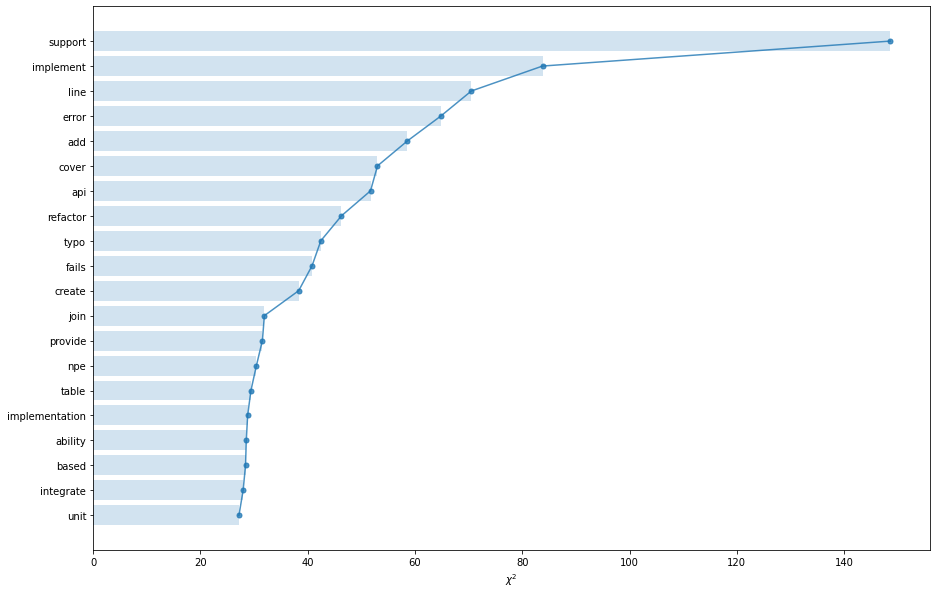

In [22]:
from sklearn.feature_selection import SelectKBest, chi2

Xtfidf_train, Xtfidf_test, y_train, y_test = train_test_split(X_tfidf, df['class'], test_size=0.30, random_state=123)

chi2score = chi2(X_tfidf, df['class'])[0]

plt.figure(figsize=(15,10))
wscores = zip(vectorizer.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$');

In [23]:
ch2_result = []
for n in np.arange(10000,100000,10000):
    ch2 = SelectKBest(chi2, k=n)
    x_train_chi2_selected = ch2.fit_transform(Xtfidf_train, y_train)
    x_validation_chi2_selected = ch2.transform(Xtfidf_test)
    clf = LogisticRegression()
    clf.fit(x_train_chi2_selected, y_train)
    score = clf.score(x_validation_chi2_selected, y_test)
    ch2_result.append(score)
    print(f"chi2 feature selection evaluation calculated for {n} features")

chi2 feature selection evaluation calculated for 10000 features
chi2 feature selection evaluation calculated for 20000 features


/Users/jordi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


chi2 feature selection evaluation calculated for 30000 features
chi2 feature selection evaluation calculated for 40000 features
chi2 feature selection evaluation calculated for 50000 features
chi2 feature selection evaluation calculated for 60000 features
chi2 feature selection evaluation calculated for 70000 features


ValueError: k should be >=0, <= n_features = 77552; got 80000. Use k='all' to return all features.

In [24]:
ch2_result

[0.6546061944397259,
 0.6567578279825604,
 0.6585697299133685,
 0.6570409376592492,
 0.6563614744351962,
 0.6574939131419512,
 0.6567012060472227]

## Prediction of the number of commits / lines changed / files changed

In [13]:
X_train_nc, X_test_nc, y_train_nc, y_test_nc = train_test_split(X_svd, df['num_commits'], test_size=0.30, random_state=123)

In [14]:
clf = LogisticRegression().fit(X_train_nc, y_train_nc)
clf.score(X_train_nc, y_train_nc), clf.score(X_test_nc, y_test_nc)

KeyboardInterrupt: 

In [ ]:
gnb = GaussianNB().fit(X_train_nc, y_train_nc)
gnb.score(X_train_nc, y_train_nc), gnb.score(X_test_nc, y_test_nc)

In [ ]:
rfc = RandomForestClassifier(max_depth=5,n_estimators=500).fit(X_train_nc, y_train_nc)
rfc.score(X_train_nc, y_train_nc), rfc.score(X_test_nc, y_test_nc)